<a href="https://colab.research.google.com/github/riazahmedmahin/Thesiss/blob/main/multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:


# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3, EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Dataset paths
train_path = '/content/drive/MyDrive/Colab Notebooks/Orage Dataset/batch 2/train'
test_path = '/content/drive/MyDrive/Colab Notebooks/Orage Dataset/batch 2/test'

# Count images in each class
def count_images_in_dir(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        class_counts[class_name] = len(os.listdir(class_dir))
    return class_counts

print("Training data:", count_images_in_dir(train_path))
print("Testing data:", count_images_in_dir(test_path))


Training data: {'grenning': 347, 'fresh': 1310, 'canker': 179, 'blackspot': 184}
Testing data: {'fresh': 273, 'blackspot': 22, 'grenning': 22, 'canker': 22}


In [ ]:
# Data augmentation settings
data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Image sizes for each model
image_size_dict = {
    'ResNet50': 224,
    'VGG16': 224,
    'EfficientNetB3': 224,
    'InceptionV3': 299
}

# Function to create data generators based on model input size
def create_data_generators(image_size):
    train_gen = data_gen.flow_from_directory(
        train_path,
        target_size=(image_size, image_size),
        batch_size=32,
        class_mode='categorical'
    )

    test_gen = data_gen.flow_from_directory(
        test_path,
        target_size=(image_size, image_size),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )

    return train_gen, test_gen

# Data generators for each model
train_gen_resnet, test_gen_resnet = create_data_generators(image_size_dict['ResNet50'])
train_gen_vgg, test_gen_vgg = create_data_generators(image_size_dict['VGG16'])
train_gen_efficientnet, test_gen_efficientnet = create_data_generators(image_size_dict['EfficientNetB3'])
train_gen_inception, test_gen_inception = create_data_generators(image_size_dict['InceptionV3'])


Found 2020 images belonging to 4 classes.
Found 339 images belonging to 4 classes.
Found 2020 images belonging to 4 classes.
Found 339 images belonging to 4 classes.
Found 2020 images belonging to 4 classes.
Found 339 images belonging to 4 classes.
Found 2020 images belonging to 4 classes.
Found 339 images belonging to 4 classes.


In [ ]:
# General function to set up transfer learning model
def setup_transfer_model(base_model, num_classes=4):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the lower layers
    for layer in base_model.layers:
        layer.trainable = False

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.005), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
# ResNet50 model setup
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_model = setup_transfer_model(resnet_base)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# VGG16 model setup
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_model = setup_transfer_model(vgg_base)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
# InceptionV3 model setup
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
inception_model = setup_transfer_model(inception_base)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# EfficientNetB3 model setup
efficientnet_base = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
efficientnet_model = setup_transfer_model(efficientnet_base)


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Function to train model and capture training time
from tensorflow.keras.callbacks import EarlyStopping

def train_model(model, train_gen, test_gen, epochs=15):
    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

    # Start training with early stopping
    start_time = time.time()
    history = model.fit(
        train_gen,
        validation_data=test_gen,
        epochs=epochs,
        callbacks=[early_stopping]
    )
    training_time = time.time() - start_time
    return history, training_time


In [ ]:
# Train ResNet50
history_resnet, training_time_resnet = train_model(resnet_model, train_gen_resnet, test_gen_resnet)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


64/64 ━━━━━━━━━━━━━━━━━━━━ 665s 9s/step - accuracy: 0.5801 - loss: 1.2446 - val_accuracy: 0.8053 - val_loss: 0.8509
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 506s 7s/step - accuracy: 0.6270 - loss: 1.0357 - val_accuracy: 0.8053 - val_loss: 0.8068
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 470s 7s/step - accuracy: 0.6155 - loss: 1.0255 - val_accuracy: 0.8053 - val_loss: 0.7850
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 502s 7s/step - accuracy: 0.6347 - loss: 0.9924 - val_accuracy: 0.8053 - val_loss: 0.7254
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 502s 7s/step - accuracy: 0.6426 - loss: 0.9904 - val_accuracy: 0.8024 - val_loss: 0.7118
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 470s 7s/step - accuracy: 0.6205 - loss: 0.9943 - val_accuracy: 0.8053 - val_loss: 0.6499
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 481s 7s/step - accuracy: 0.6509 - loss: 0.9346 - val_accuracy: 0.8053 - val_loss: 0.7475
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 459s 7s/step - accuracy: 0.6163 - loss: 0.9788 - val_accuracy: 0.8053 - val_loss: 0.

In [ ]:
# Function to evaluate the model and print metrics
def evaluate_model(model, test_gen):
    predictions = model.predict(test_gen)
    y_true = test_gen.classes
    y_pred = np.argmax(predictions, axis=1)

    print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


11/11 ━━━━━━━━━━━━━━━━━━━━ 69s 6s/step
              precision    recall  f1-score   support

   blackspot       0.00      0.00      0.00        22
      canker       1.00      0.09      0.17        22
       fresh       0.81      1.00      0.90       273
    grenning       0.00      0.00      0.00        22

    accuracy                           0.81       339
   macro avg       0.45      0.27      0.27       339
weighted avg       0.72      0.81      0.73       339



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


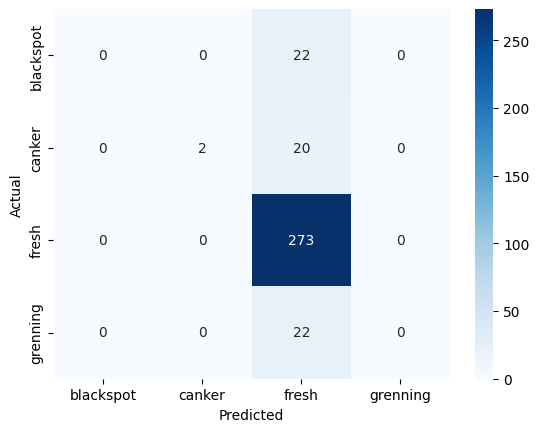

In [ ]:
# Evaluate ResNet50
evaluate_model(resnet_model, test_gen_resnet)


In [ ]:
# Define the save path
save_path = '/content/drive/MyDrive/Colab Notebooks/Orage Dataset/ExtractedFeature/multiclass'

# Save each model's weights and structure
resnet_model.save(f"{save_path}/resnet50_orange_disease.h5")


In [ ]:
# Function to print the final test accuracy of a trained model
def print_model_accuracy(model, test_gen, model_name):
    # Evaluate the model on the test set
    _, accuracy = model.evaluate(test_gen, verbose=0)
    print(f"Final Test Accuracy for {model_name}: {accuracy * 100:.2f}%")

# Print accuracy for each model
print_model_accuracy(resnet_model, test_gen_resnet, "ResNet-50")


Final Test Accuracy for ResNet-50: 80.53%


In [ ]:
# Train VGG16
history_vgg, training_time_vgg = train_model(vgg_model, train_gen_vgg, test_gen_vgg)


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


64/64 ━━━━━━━━━━━━━━━━━━━━ 1885s 27s/step - accuracy: 0.6196 - loss: 1.0256 - val_accuracy: 0.8643 - val_loss: 0.3629
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1374s 21s/step - accuracy: 0.8052 - loss: 0.5442 - val_accuracy: 0.9086 - val_loss: 0.2769
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1401s 21s/step - accuracy: 0.8585 - loss: 0.4068 - val_accuracy: 0.9351 - val_loss: 0.2357
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1389s 21s/step - accuracy: 0.8624 - loss: 0.3686 - val_accuracy: 0.9440 - val_loss: 0.1960
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1362s 21s/step - accuracy: 0.8763 - loss: 0.3261 - val_accuracy: 0.9351 - val_loss: 0.1970
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1363s 21s/step - accuracy: 0.9076 - loss: 0.2678 - val_accuracy: 0.9558 - val_loss: 0.1729
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1412s 21s/step - accuracy: 0.9060 - loss: 0.2511 - val_accuracy: 0.9440 - val_loss: 0.1541
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1367s 21s/step - accuracy: 0.9129 - loss: 0.2713 - val_accuracy: 0.958

In [ ]:
# Function to evaluate the model and print metrics
def evaluate_model(model, test_gen):
    predictions = model.predict(test_gen)
    y_true = test_gen.classes
    y_pred = np.argmax(predictions, axis=1)

    print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


11/11 ━━━━━━━━━━━━━━━━━━━━ 199s 18s/step
              precision    recall  f1-score   support

   blackspot       1.00      0.82      0.90        22
      canker       0.83      0.86      0.84        22
       fresh       0.98      1.00      0.99       273
    grenning       1.00      0.91      0.95        22

    accuracy                           0.97       339
   macro avg       0.95      0.90      0.92       339
weighted avg       0.97      0.97      0.97       339



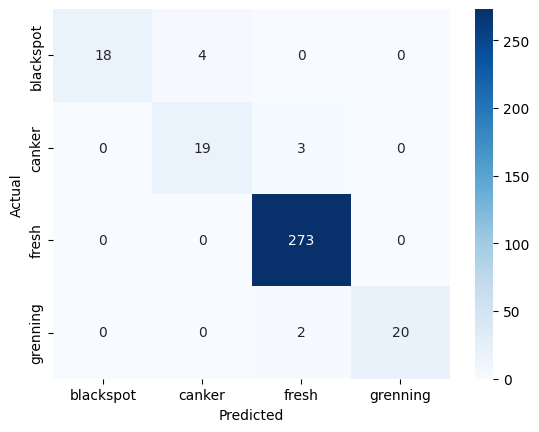

In [ ]:
# Evaluate VGG16
evaluate_model(vgg_model, test_gen_vgg)


In [ ]:
# Define the save path
save_path = '/content/drive/MyDrive/Colab Notebooks/Orage Dataset/ExtractedFeature/multiclass'

# Save each model's weights and structure
vgg_model.save(f"{save_path}/vgg16_orange_disease.h5")

In [ ]:
# Train InceptionV3
history_inception, training_time_inception = train_model(inception_model, train_gen_inception, test_gen_inception)


Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 633s 10s/step - accuracy: 0.7705 - loss: 0.6161 - val_accuracy: 0.9764 - val_loss: 0.0755
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 630s 10s/step - accuracy: 0.9669 - loss: 0.0877 - val_accuracy: 0.9587 - val_loss: 0.0829
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 685s 10s/step - accuracy: 0.9710 - loss: 0.0720 - val_accuracy: 0.9764 - val_loss: 0.0695
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 676s 10s/step - accuracy: 0.9803 - loss: 0.0528 - val_accuracy: 0.9853 - val_loss: 0.0537
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 636s 10s/step - accuracy: 0.9724 - loss: 0.0738 - val_accuracy: 0.9853 - val_loss: 0.0402
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 729s 10s/step - accuracy: 0.9882 - loss: 0.0411 - val_accuracy: 0.9823 - val_loss: 0.0584
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 689s 11s/step - accuracy: 0.9754 - loss: 0.0541 - val_accuracy: 0.9882 - val_loss: 0.0509
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 680s 11s/step - accuracy: 0.9810 - loss: 0.0409 - val_accuracy: 0.

In [ ]:
# Function to evaluate the model and print metrics
def evaluate_model(model, test_gen):
    predictions = model.predict(test_gen)
    y_true = test_gen.classes
    y_pred = np.argmax(predictions, axis=1)

    print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


11/11 ━━━━━━━━━━━━━━━━━━━━ 98s 9s/step
              precision    recall  f1-score   support

   blackspot       0.88      0.95      0.91        22
      canker       0.94      0.73      0.82        22
       fresh       0.99      1.00      0.99       273
    grenning       1.00      1.00      1.00        22

    accuracy                           0.98       339
   macro avg       0.95      0.92      0.93       339
weighted avg       0.98      0.98      0.98       339



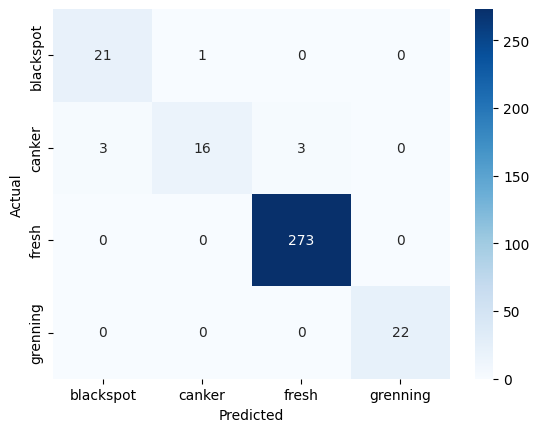

In [ ]:
# Evaluate InceptionV3
evaluate_model(inception_model, test_gen_inception)


In [ ]:
# Define the save path
save_path = '/content/drive/MyDrive/Colab Notebooks/Orage Dataset/ExtractedFeature/multiclass'

# Save each model's weights and structure
inception_model.save(f"{save_path}/inceptionv3_orange_disease.h5")

In [ ]:
# Function to print the final test accuracy of a trained model
def print_model_accuracy(model, test_gen, model_name):
    # Evaluate the model on the test set
    _, accuracy = model.evaluate(test_gen, verbose=0)
    print(f"Final Test Accuracy for {model_name}: {accuracy * 100:.2f}%")

# Print accuracy for each model
print_model_accuracy(inception_model, test_gen_inception, "InceptionV3")

Final Test Accuracy for InceptionV3: 98.53%


In [ ]:
# Train EfficientNetB3
history_efficientnet, training_time_efficientnet = train_model(efficientnet_model, train_gen_efficientnet, test_gen_efficientnet)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


64/64 ━━━━━━━━━━━━━━━━━━━━ 443s 7s/step - accuracy: 0.6166 - loss: 1.1579 - val_accuracy: 0.8053 - val_loss: 0.7526
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 429s 6s/step - accuracy: 0.6238 - loss: 1.1063 - val_accuracy: 0.8053 - val_loss: 0.7492
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 412s 6s/step - accuracy: 0.6254 - loss: 1.1091 - val_accuracy: 0.8053 - val_loss: 0.8003
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 408s 6s/step - accuracy: 0.6627 - loss: 1.0470 - val_accuracy: 0.8053 - val_loss: 0.8810
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 397s 6s/step - accuracy: 0.6452 - loss: 1.0965 - val_accuracy: 0.8053 - val_loss: 0.7549
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 404s 6s/step - accuracy: 0.6285 - loss: 1.1349 - val_accuracy: 0.8053 - val_loss: 0.8347
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 458s 6s/step - accuracy: 0.6496 - loss: 1.0764 - val_accuracy: 0.8053 - val_loss: 0.7661
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 399s 6s/step - accuracy: 0.6363 - loss: 1.0907 - val_accuracy: 0.8053 - val_loss: 0.

In [ ]:
# Function to evaluate the model and print metrics
def evaluate_model(model, test_gen):
    predictions = model.predict(test_gen)
    y_true = test_gen.classes
    y_pred = np.argmax(predictions, axis=1)

    print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


11/11 ━━━━━━━━━━━━━━━━━━━━ 61s 5s/step
              precision    recall  f1-score   support

   blackspot       0.00      0.00      0.00        22
      canker       0.00      0.00      0.00        22
       fresh       0.81      1.00      0.89       273
    grenning       0.00      0.00      0.00        22

    accuracy                           0.81       339
   macro avg       0.20      0.25      0.22       339
weighted avg       0.65      0.81      0.72       339



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


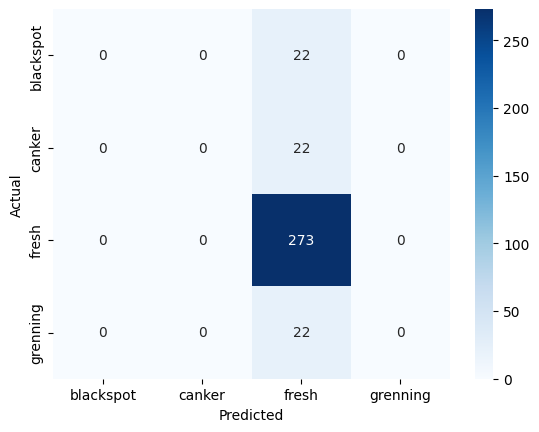

In [ ]:
# Evaluate EfficientNetB3
evaluate_model(efficientnet_model, test_gen_efficientnet)


In [ ]:
# Function to print the final test accuracy of a trained model
def print_model_accuracy(model, test_gen, model_name):
    # Evaluate the model on the test set
    _, accuracy = model.evaluate(test_gen, verbose=0)
    print(f"Final Test Accuracy for {model_name}: {accuracy * 100:.2f}%")

# Print accuracy for each model
print_model_accuracy(efficientnet_model, test_gen_efficientnet, "EfficientNet-B3")


Final Test Accuracy for EfficientNet-B3: 80.53%


In [ ]:
# Define the save path
save_path = '/content/drive/MyDrive/Colab Notebooks/Orage Dataset/ExtractedFeature/multiclass'

# Save each model's weights and structure
efficientnet_model.save(f"{save_path}/efficientnetb3_orange_disease.h5")
